## Environmental Source Apportionment Toolkit (ESAT) Cross-Validation

*** TESTING NOTEBOOK ***

This notebook is intended to test implementations of cross-validation of SA models for the purpose of estimating the optimal number of factors for a given dataset.

The starting reference for this approach: http://alexhwilliams.info/itsneuronalblog/2018/02/26/crossval/

Once an automated process has been developed, the approach can be validated using the synthetic data developed from the ESAT simulator.


In [1]:
# Notebook imports
import os
import sys
import json
import copy
import numpy as np
import pandas as pd
import multiprocessing as mp
from tqdm import tqdm
from scipy.cluster.vq import whiten
import plotly.graph_objects as go

#### Code Imports

In [2]:
from esat.data.datahandler import DataHandler
from esat.model.sa import SA
from esat.model.batch_sa import BatchSA
from esat.data.analysis import ModelAnalysis, BatchAnalysis
from esat.metrics import q_loss
from esat_eval.simulator import Simulator

#### Sample Dataset
The three sample datasets from PMF5 are available for use, but a new dataset can be used in their place.

In [3]:
# Synethic dataset parameters
seed = 42
syn_factors = 7                # Number of factors in the synthetic dataset
syn_features = 40              # Number of features in the synthetic dataset
syn_samples = 300             # Number of samples in the synthetic dataset
outliers = True                # Add outliers to the dataset
outlier_p = 0.10               # Decimal percent of outliers in the dataset
outlier_mag = 1.25                # Magnitude of outliers
contribution_max = 2           # Maximum value of the contribution matrix (W) (Randomly sampled from a uniform distribution)
noise_mean_min = 0.03          # Min value for the mean of noise added to the synthetic dataset, used to randomly determine the mean decimal percentage of the noise for each feature.
noise_mean_max = 0.05          # Max value for the mean of noise added to the synthetic dataset, used to randomly determine the mean decimal percentage of the noise for each feature.
noise_scale = 0.02             # Scale of the noise added to the synthetic dataset
uncertainty_mean_min = 0.04    # Min value for the mean uncertainty of a data feature, used to randomly determine the mean decimal percentage for each feature in the uncertainty dataset. 
uncertainty_mean_max = 0.06    # Max value for the mean uncertainty of a data feature, used to randomly determine the mean decimal percentage for each feature in the uncertainty dataset. 
uncertainty_scale = 0.01       # Scale of the uncertainty matrix

In [4]:
# Initialize the simulator with the above parameters
simulator = Simulator(seed=seed,
                      factors_n=syn_factors,
                      features_n=syn_features,
                      samples_n=syn_samples,
                      outliers=outliers,
                      outlier_p=outlier_p,
                      outlier_mag=outlier_mag,
                      contribution_max=contribution_max,
                      noise_mean_min=noise_mean_min,
                      noise_mean_max=noise_mean_max,
                      noise_scale=noise_scale,
                      uncertainty_mean_min=uncertainty_mean_min,
                      uncertainty_mean_max=uncertainty_mean_max,
                      uncertainty_scale=uncertainty_scale
                     )

08-May-24 17:47:31 - Synthetic profiles generated


In [5]:
cwd = os.getcwd()
data_dir = os.path.join(cwd, "..", "data")

# Baton Rouge Dataset
br_input_file = os.path.join(data_dir, "Dataset-BatonRouge-con.csv")
br_uncertainty_file = os.path.join(data_dir, "Dataset-BatonRouge-unc.csv")
br_output_path = os.path.join(data_dir, "output", "BatonRouge")
# Baltimore Dataset
b_input_file = os.path.join(data_dir, "Dataset-Baltimore_con.txt")
b_uncertainty_file = os.path.join(data_dir, "Dataset-Baltimore_unc.txt")
b_output_path = os.path.join(data_dir, "output", "Baltimore")
# Saint Louis Dataset
sl_input_file = os.path.join(data_dir, "Dataset-StLouis-con.csv")
sl_uncertainty_file = os.path.join(data_dir, "Dataset-StLouis-unc.csv")
sl_output_path = os.path.join(data_dir, "output", "StLouis")

#### Dataset Selection
One of the three sample datasets can be selected or a new cleaned dataset can be used. Datasets should be cleaned, containing no missing data (either dropping missing/NaNs, or interpolating the missing values).

In [6]:
# Loading the Baton Rouge dataset
# input_file = br_input_file
# uncertainty_file = br_uncertainty_file
input_data_df, uncertainty_data_df = simulator.get_data()

08-May-24 17:47:32 - Synthetic data generated
08-May-24 17:47:32 - Synthetic uncertainty data generated
08-May-24 17:47:32 - Synthetic dataframes completed
08-May-24 17:47:32 - Synthetic source apportionment instance created.


#### Load Data
Assign the processed data and uncertainty datasets to the variables V and U. These steps will be simplified/streamlined in a future version of the code.

In [7]:
# data_handler = DataHandler(
#     input_path=input_file,
#     uncertainty_path=uncertainty_file,
#     index_col='date'
# )
data_handler = DataHandler.load_dataframe(input_df=input_data_df, uncertainty_df=uncertainty_data_df)

In [8]:
# Get the processed data and uncertainty
V, U = data_handler.get_data()

#### Cross-Validation

For a series of factors counts, i.e. 3->12, train a model(s) using the standard input data that has been masked. The mask is a binary matrix that indicates the cells in V and U which are used for training and validation testing. The selection of these cells will be random for each test.

The mask will contain some percentage of the data points, the MSE will be evaluated for both training data (mask=1) and the testing data (mask=0). The point on the slope where the test data stops decreases is the proposed optimal number of factors/components.

Tests will include using this method on a single model and averaging batch solutions.


In [9]:
from esat.helpers import FSearch

In [12]:
factor_search = FSearch(V=V, U=U)
results = factor_search.search(samples=400, min_factors=2, max_factors=12)
results

Rapid random sampling for factor estimation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [02:17<00:00,  2.91it/s]
08-May-24 17:51:08 - Estimated factor count: 7


,Factors,Test MSE,Train MSE,Delta MSE,Delta Ratio
0,2,-0.446922,0.359571,NaN,NaN
1,3,-0.315428,0.267548,-0.131494,1.377104
2,4,-0.219946,0.191512,-0.095481,1.221045
3,5,-0.141754,0.122581,-0.078192,1.243992
4,6,-0.078904,0.069589,-0.062851,1.268108
5,7,-0.029346,0.026552,-0.049558,12.694579
6,8,-0.025447,0.024362,-0.003899,8.032568
7,9,-0.024966,0.023924,-0.000481,0.644237
8,10,-0.024225,0.023374,-0.000741,1.178489
9,11,-0.023601,0.022752,-0.000624,0.988194


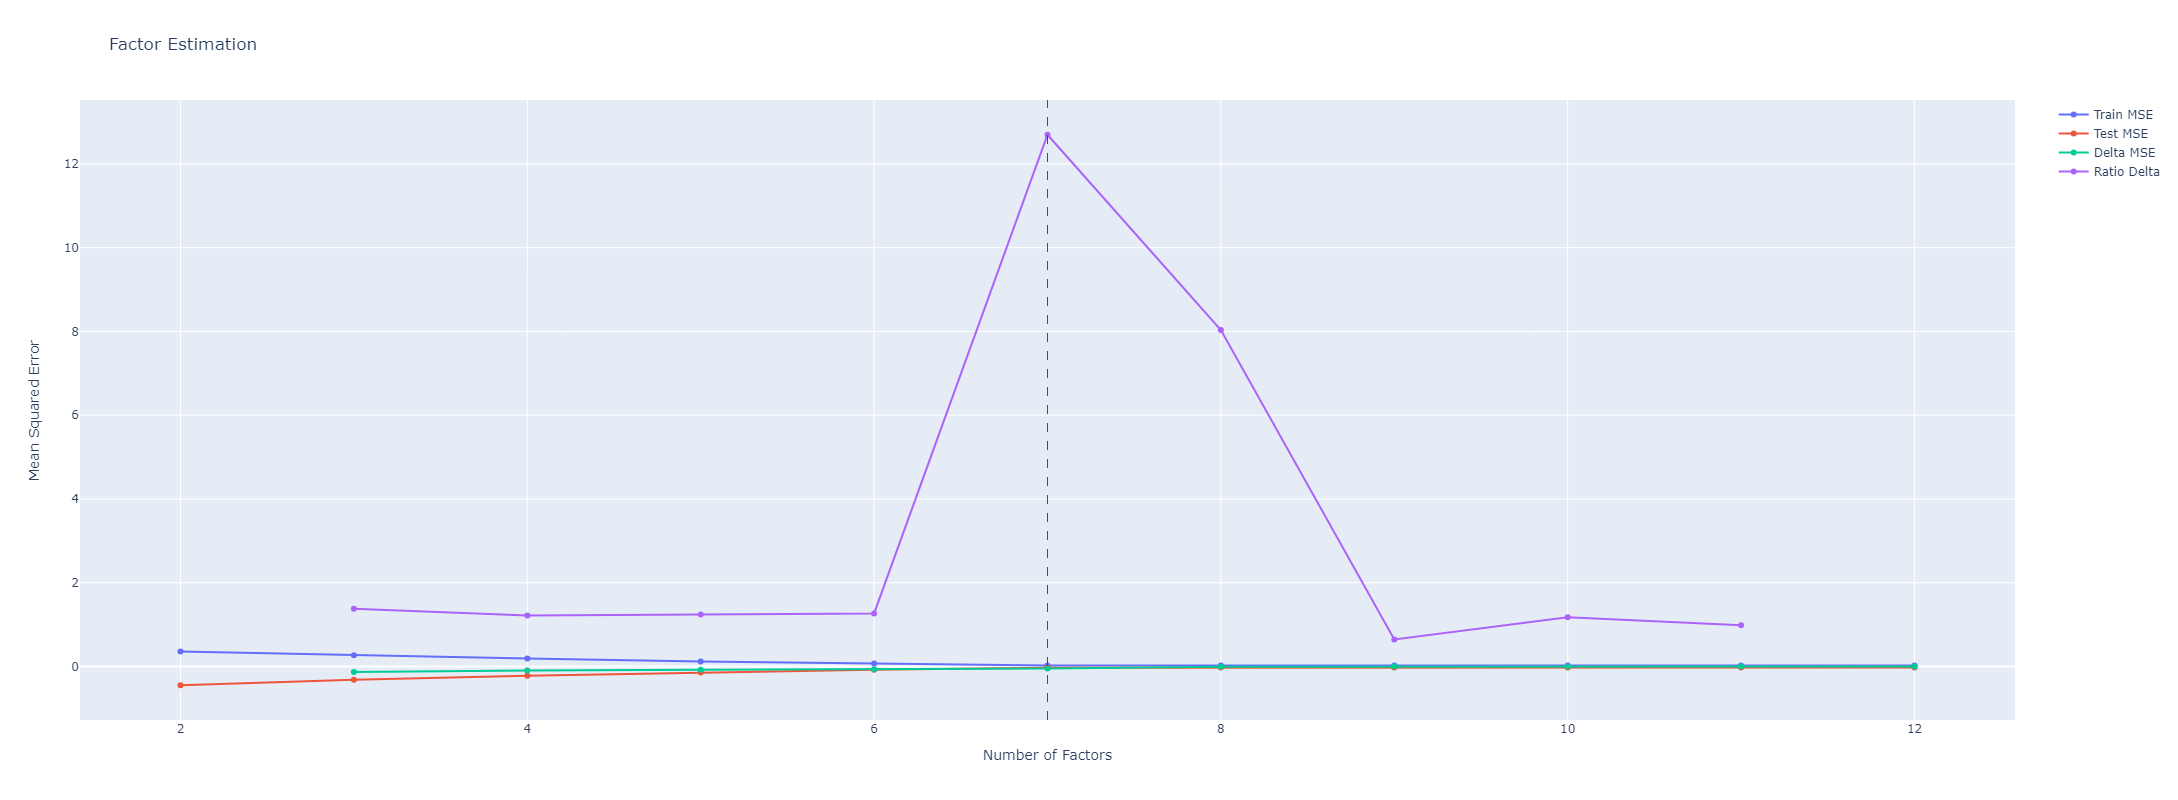

In [13]:
factor_search.plot(actual_count=syn_factors)